In [1]:
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [38]:
import json
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def load_tacred_dataset(file_path):
    """
    Load the TACRED dataset from a JSON file.

    Args:
    file_path (str): The path to the JSON file containing the dataset.

    Returns:
    dict: The loaded dataset.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [4]:
def extract_context_features(tokens, pos_tags, ner_tags, subj_start, subj_end, obj_start, obj_end, context_size=2):
    """
    Extracts context vocabulary and context entity types around subject and object entities.

    Parameters:
    - tokens: List of tokens in the sentence.
    - pos_tags: List of POS tags for each token.
    - ner_tags: List of NER tags for each token.
    - subj_start, subj_end: Start and end indices of the subject entity.
    - obj_start, obj_end: Start and end indices of the object entity.
    - context_size: Number of tokens to consider around each entity for context.

    Returns:
    A dictionary containing context words and POS tags for subject and object,
    and types of other entities in the sentence.
    """

    # Initialize the result dictionary
    features = {
        'subj_context_words': [],
        'subj_context_pos': [],
        'obj_context_words': [],
        'obj_context_pos': [],
        'other_entity_types': []
    }

    # Helper function to get context words and POS tags
    def get_context(entity_start, entity_end, context_size):
        context_words = []
        context_pos = []
        for i in range(max(0, entity_start - context_size), min(len(tokens), entity_end + context_size + 1)):
            # Exclude the entity itself
            if i < entity_start or i > entity_end:
                context_words.append(tokens[i])
                context_pos.append(pos_tags[i])
        return context_words, context_pos

    # Extract context for subject and object entities
    features['subj_context_words'], features['subj_context_pos'] = get_context(subj_start, subj_end, context_size)
    features['obj_context_words'], features['obj_context_pos'] = get_context(obj_start, obj_end, context_size)

    # Extract types of other entities in the sentence
    for i, tag in enumerate(ner_tags):
        if tag != 'O' and not (subj_start <= i <= subj_end) and not (obj_start <= i <= obj_end):
            features['other_entity_types'].append(tag)

    return features

In [5]:
# 列表元素
keys = ['no_relation', 'per:title', 'org:top_members/employees',
        'org:country_of_headquarters', 'per:parents', 'per:age',
        'per:countries_of_residence', 'per:children', 'org:alternate_names',
        'per:charges', 'per:cities_of_residence', 'per:origin', 'org:founded_by',
        'per:employee_of', 'per:siblings', 'per:alternate_names', 'org:website',
        'per:religion', 'per:stateorprovince_of_death', 'org:parents',
        'org:subsidiaries', 'per:other_family', 'per:stateorprovinces_of_residence',
        'org:members', 'per:cause_of_death', 'org:member_of',
        'org:number_of_employees/members', 'per:country_of_birth',
        'org:shareholders', 'org:stateorprovince_of_headquarters',
        'per:city_of_death', 'per:date_of_birth', 'per:spouse',
        'org:city_of_headquarters', 'per:date_of_death', 'per:schools_attended',
        'org:political/religious_affiliation', 'per:country_of_death',
        'org:founded', 'per:stateorprovince_of_birth', 'per:city_of_birth',
        'org:dissolved']

# 为列表元素分配顺序并存储到字典中
key_to_index = {key: idx for idx, key in enumerate(keys)}

print(key_to_index)


{'no_relation': 0, 'per:title': 1, 'org:top_members/employees': 2, 'org:country_of_headquarters': 3, 'per:parents': 4, 'per:age': 5, 'per:countries_of_residence': 6, 'per:children': 7, 'org:alternate_names': 8, 'per:charges': 9, 'per:cities_of_residence': 10, 'per:origin': 11, 'org:founded_by': 12, 'per:employee_of': 13, 'per:siblings': 14, 'per:alternate_names': 15, 'org:website': 16, 'per:religion': 17, 'per:stateorprovince_of_death': 18, 'org:parents': 19, 'org:subsidiaries': 20, 'per:other_family': 21, 'per:stateorprovinces_of_residence': 22, 'org:members': 23, 'per:cause_of_death': 24, 'org:member_of': 25, 'org:number_of_employees/members': 26, 'per:country_of_birth': 27, 'org:shareholders': 28, 'org:stateorprovince_of_headquarters': 29, 'per:city_of_death': 30, 'per:date_of_birth': 31, 'per:spouse': 32, 'org:city_of_headquarters': 33, 'per:date_of_death': 34, 'per:schools_attended': 35, 'org:political/religious_affiliation': 36, 'per:country_of_death': 37, 'org:founded': 38, 'per

In [6]:
# Load the TACRED training dataset
train_data = load_tacred_dataset('/content/Drive/MyDrive/tacred/data/json/train.json')

# Load the TACRED test dataset
test_data = load_tacred_dataset('/content/Drive/MyDrive/tacred/data/json/test.json')

In [7]:
for key, value in train_data[0].items():
    print(f"{key}: {value}")

id: 61b3a5c8c9a882dcfcd2
docid: AFP_ENG_20070218.0019.LDC2009T13
relation: org:founded_by
token: ['Tom', 'Thabane', 'resigned', 'in', 'October', 'last', 'year', 'to', 'form', 'the', 'All', 'Basotho', 'Convention', '-LRB-', 'ABC', '-RRB-', ',', 'crossing', 'the', 'floor', 'with', '17', 'members', 'of', 'parliament', ',', 'causing', 'constitutional', 'monarch', 'King', 'Letsie', 'III', 'to', 'dissolve', 'parliament', 'and', 'call', 'the', 'snap', 'election', '.']
subj_start: 10
subj_end: 12
obj_start: 0
obj_end: 1
subj_type: ORGANIZATION
obj_type: PERSON
stanford_pos: ['NNP', 'NNP', 'VBD', 'IN', 'NNP', 'JJ', 'NN', 'TO', 'VB', 'DT', 'DT', 'NNP', 'NNP', '-LRB-', 'NNP', '-RRB-', ',', 'VBG', 'DT', 'NN', 'IN', 'CD', 'NNS', 'IN', 'NN', ',', 'VBG', 'JJ', 'NN', 'NNP', 'NNP', 'NNP', 'TO', 'VB', 'NN', 'CC', 'VB', 'DT', 'NN', 'NN', '.']
stanford_ner: ['PERSON', 'PERSON', 'O', 'O', 'DATE', 'DATE', 'DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'NUMBER', 'O',

In [8]:
# Create a DataFrame from the TACRED training dataset
train_df = pd.DataFrame(train_data)

# Add a new column 'relation_id' containing the factorized values of the 'relation' column
train_df['relation_id'] = train_df['relation'].map(key_to_index)

# Display the first few rows of the DataFrame
train_df.head()

,id,docid,relation,token,subj_start,subj_end,obj_start,obj_end,subj_type,obj_type,stanford_pos,stanford_ner,stanford_head,stanford_deprel,relation_id
0,61b3a5c8c9a882dcfcd2,AFP_ENG_20070218.0019.LDC2009T13,org:founded_by,"[Tom, Thabane, resigned, in, October, last, ye...",10,12,0,1,ORGANIZATION,PERSON,"[NNP, NNP, VBD, IN, NNP, JJ, NN, TO, VB, DT, D...","[PERSON, PERSON, O, O, DATE, DATE, DATE, O, O,...","[2, 3, 0, 5, 3, 7, 3, 9, 3, 13, 13, 13, 9, 15,...","[compound, nsubj, ROOT, case, nmod, amod, nmod...",12
1,61b3a65fb9b7111c4ca4,NYT_ENG_20071026.0056.LDC2009T13,no_relation,"[In, 1983, ,, a, year, after, the, rally, ,, F...",9,9,19,20,PERSON,PERSON,"[IN, CD, ,, DT, NN, IN, DT, NN, ,, NNP, VBD, D...","[O, DATE, O, DURATION, DURATION, O, O, O, O, P...","[2, 11, 11, 5, 11, 8, 8, 5, 11, 11, 0, 16, 16,...","[case, nmod, punct, det, nmod:tmod, case, det,...",0
2,61b3a65fb9aeb61c81e7,eng-NG-31-126955-9171242,no_relation,"[This, was, among, a, batch, of, paperback, Ox...",26,26,7,8,ORGANIZATION,ORGANIZATION,"[DT, VBD, IN, DT, NN, IN, NN, NNP, NNP, POS, N...","[O, O, O, O, O, O, O, ORGANIZATION, ORGANIZATI...","[5, 5, 5, 5, 0, 11, 9, 9, 11, 9, 5, 15, 15, 15...","[nsubj, cop, case, det, ROOT, case, compound, ...",0
3,61b3a65fb9c9956eccbc,APW_ENG_20100119.0780,no_relation,"[The, latest, investigation, was, authorized, ...",55,55,28,29,ORGANIZATION,NUMBER,"[DT, JJS, NN, VBD, VBN, IN, DT, NNP, NNP, IN, ...","[O, O, O, O, O, O, O, ORGANIZATION, ORGANIZATI...","[3, 3, 5, 5, 0, 9, 9, 9, 5, 11, 5, 5, 21, 13, ...","[det, amod, nsubjpass, auxpass, ROOT, case, de...",0
4,61b3a65fb9197aba87ff,APW_ENG_20070501.0905.LDC2009T13,no_relation,"[The, event, is, a, response, to, a, White, Ho...",23,26,13,13,ORGANIZATION,DATE,"[DT, NN, VBZ, DT, NN, TO, DT, NNP, NNP, NN, NN...","[O, O, O, O, O, O, O, ORGANIZATION, ORGANIZATI...","[2, 5, 5, 5, 16, 12, 12, 12, 12, 12, 12, 5, 14...","[det, nsubj, cop, det, ccomp, case, det, compo...",0


In [9]:
u1 = train_df['relation_id'].unique()
print(u1)
u2 = train_df['subj_type'].unique()
print(u2)
u3 = train_df['obj_type'].unique()
print(u3)

[12  0 13  8 10  7  1 14 17  5 16 22 25  2  6 33 23  3 32 29 26 19 20 11
 36 21 39 41 34 28 15  4 35 24 30 18 38 27 31 40  9 37]
['ORGANIZATION' 'PERSON']
['PERSON' 'ORGANIZATION' 'NUMBER' 'DATE' 'NATIONALITY' 'LOCATION' 'TITLE'
 'CITY' 'MISC' 'COUNTRY' 'CRIMINAL_CHARGE' 'RELIGION' 'DURATION' 'URL'
 'STATE_OR_PROVINCE' 'IDEOLOGY' 'CAUSE_OF_DEATH']


In [10]:
# Create a DataFrame from the TACRED test dataset
test_df = pd.DataFrame(test_data)

# Add a new column 'relation_id' containing the factorized values of the 'relation' column
test_df['relation_id'] = test_df['relation'].map(key_to_index)

# Display the first few rows of the DataFrame
test_df.head()

,id,docid,relation,token,subj_start,subj_end,obj_start,obj_end,subj_type,obj_type,stanford_pos,stanford_ner,stanford_head,stanford_deprel,relation_id
0,098f665fb966708cfcd2,eng-NG-31-101172-8859554,no_relation,"[He, has, served, as, a, policy, aide, to, the...",33,36,43,45,ORGANIZATION,ORGANIZATION,"[PRP, VBZ, VBN, IN, DT, NN, NN, TO, DT, JJ, NN...","[O, O, O, O, O, O, O, O, O, O, LOCATION, O, PE...","[3, 3, 0, 7, 7, 7, 3, 14, 14, 14, 14, 14, 14, ...","[nsubj, aux, ROOT, case, det, compound, nmod, ...",0
1,098f665fb90bef0c4ca4,APW_ENG_20090616.0636,no_relation,"[Messina, Denaro, has, been, trying, to, impos...",7,7,10,10,PERSON,CITY,"[NNP, NNP, VBZ, VBN, VBG, TO, VB, PRP$, NN, IN...","[PERSON, PERSON, O, O, O, O, O, O, O, O, LOCAT...","[2, 5, 5, 5, 0, 7, 5, 9, 7, 11, 7, 5, 15, 15, ...","[compound, nsubj, aux, aux, ROOT, mark, xcomp,...",0
2,098f665fb9ef7dbc81e7,XIN_ENG_20100801.0069,no_relation,"[Eugenio, Vagni, ,, the, Italian, worker, of, ...",0,1,15,15,PERSON,COUNTRY,"[NNP, NNP, ,, DT, JJ, NN, IN, DT, NNP, ,, CC, ...","[PERSON, PERSON, O, O, MISC, O, O, O, ORGANIZA...","[2, 25, 2, 6, 6, 2, 9, 9, 6, 2, 2, 14, 14, 2, ...","[compound, nsubjpass, punct, det, amod, appos,...",0
3,098f665fb9560e2eccbc,NYT_ENG_20080704.0127.LDC2009T13,no_relation,"[With, his, perfect, English, and, British, ed...",33,33,41,41,PERSON,MISC,"[IN, PRP$, JJ, NNP, CC, NNP, NN, -LRB-, DT, NN...","[O, O, O, MISC, O, MISC, O, O, O, O, O, O, O, ...","[4, 4, 4, 17, 4, 7, 4, 10, 10, 17, 13, 13, 10,...","[case, nmod:poss, amod, nmod, cc, compound, co...",0
4,098f665fb9cf660a87ff,AFP_ENG_20070424.0169.LDC2009T13,no_relation,"[Twenty, percent, of, those, surveyed, in, 10,...",16,19,31,31,ORGANIZATION,MISC,"[CD, NN, IN, DT, VBN, IN, CD, NNS, IN, NNP, NN...","[PERCENT, PERCENT, O, O, O, O, NUMBER, O, O, O...","[2, 34, 4, 2, 4, 8, 8, 5, 12, 12, 12, 5, 12, 1...","[nummod, nsubj, case, nmod, acl, case, nummod,...",0


In [11]:
u1 = test_df['relation_id'].unique()
print(u1)
u2 = test_df['subj_type'].unique()
print(u2)
u3 = test_df['obj_type'].unique()
print(u3)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
['ORGANIZATION' 'PERSON']
['ORGANIZATION' 'CITY' 'COUNTRY' 'MISC' 'LOCATION' 'PERSON' 'TITLE' 'URL'
 'DURATION' 'NUMBER' 'DATE' 'NATIONALITY' 'CAUSE_OF_DEATH' 'RELIGION'
 'CRIMINAL_CHARGE' 'STATE_OR_PROVINCE' 'IDEOLOGY']


In [12]:
def process_data(data):
    """
    Process the TACRED dataset to extract context features for each entry.

    Args:
    data (list): List of entries in the dataset.

    Returns:
    list: List of dictionaries containing processed context features for each entry.
    """
    processed_doc = []
    for entry in data:
        context_features = extract_context_features(entry["token"], entry["stanford_pos"], entry["stanford_ner"], entry["subj_start"], entry["subj_end"], entry["obj_start"], entry["obj_end"])
        processed_doc.append(context_features)
    return processed_doc

# Process the training dataset
train_doc = process_data(train_data)

# Process the test dataset
test_doc = process_data(test_data)

# Print the lengths of the processed datasets
print(len(train_doc))
print(len(test_doc))


68124
15509


In [13]:
def create_dataframe(doc):
    """
    Create a DataFrame from the processed context features.

    Args:
    doc (list): List of dictionaries containing processed context features.

    Returns:
    pandas.DataFrame: DataFrame containing the processed features.
    """
    # Create DataFrame from the processed context features
    df = pd.DataFrame(doc)

    # Drop columns not needed for further processing
    df = df.drop(columns=['subj_context_words', 'obj_context_words'])

    # Combine POS tags into strings
    df['A'] = df.apply(lambda row: ' '.join(row['subj_context_pos']), axis=1)
    df['B'] = df.apply(lambda row: ' '.join(row['obj_context_pos']), axis=1)
    df['C'] = df.apply(lambda row: ' '.join(row['other_entity_types']), axis=1)

    return df

# Create DataFrames for the processed training and test datasets
train_df_new = create_dataframe(train_doc)
test_df_new = create_dataframe(test_doc)

In [14]:
train_df_new

,subj_context_pos,obj_context_pos,other_entity_types,A,B,C
0,"[VB, DT, -LRB-, NNP]","[VBD, IN]","[DATE, DATE, DATE, ORGANIZATION, NUMBER, PERSO...",VB DT -LRB- NNP,VBD IN,DATE DATE DATE ORGANIZATION NUMBER PERSON PERSON
1,"[NN, ,, VBD, DT]","[IN, DT, CC, NNP]","[DATE, DURATION, DURATION, ORGANIZATION, ORGAN...","NN , VBD DT",IN DT CC NNP,DATE DURATION DURATION ORGANIZATION ORGANIZATI...
2,"[NN, IN, .]","[IN, NN, POS, NNS]",[MISC],NN IN .,IN NN POS NNS,MISC
3,"[IN, JJ, NN, IN]","[NN, -RRB-, -LRB-, RB]","[ORGANIZATION, ORGANIZATION, DATE, ORGANIZATIO...",IN JJ NN IN,NN -RRB- -LRB- RB,ORGANIZATION ORGANIZATION DATE ORGANIZATION PE...
4,"[IN, DT, .]","[NN, IN, ,, VBD]","[ORGANIZATION, ORGANIZATION, PERSON, PERSON]",IN DT .,"NN IN , VBD",ORGANIZATION ORGANIZATION PERSON PERSON
...,...,...,...,...,...,...
68119,"[CC, DT, -LRB-, NNP]","[CC, DT, -LRB-, NNP]","[ORGANIZATION, ORGANIZATION, ORGANIZATION, ORG...",CC DT -LRB- NNP,CC DT -LRB- NNP,ORGANIZATION ORGANIZATION ORGANIZATION ORGANIZ...
68120,"[JJ, NN, ,, WDT]","[VBZ, VBN]",[MISC],"JJ NN , WDT",VBZ VBN,MISC
68121,"[NN, NNP, VBD, NNP]","[CC, JJ, NN, NN]","[DURATION, DATE, LOCATION, TIME, DURATION, ORG...",NN NNP VBD NNP,CC JJ NN NN,DURATION DATE LOCATION TIME DURATION ORGANIZAT...
68122,"[NN, ,, ,, VBD]","[JJ, NN, ,, NNP]","[ORGANIZATION, ORGANIZATION, MISC]","NN , , VBD","JJ NN , NNP",ORGANIZATION ORGANIZATION MISC


In [15]:
test_df_new

,subj_context_pos,obj_context_pos,other_entity_types,A,B,C
0,"[NN, IN, CC, IN]","[IN, DT, IN, DT]","[LOCATION, PERSON, PERSON, DATE, PERSON, PERSO...",NN IN CC IN,IN DT IN DT,LOCATION PERSON PERSON DATE PERSON PERSON ORGA...
1,"[TO, VB, NN, IN]","[NN, IN, ,, DT]","[PERSON, PERSON, MISC, ORGANIZATION, ORGANIZAT...",TO VB NN IN,"NN IN , DT",PERSON PERSON MISC ORGANIZATION ORGANIZATION L...
2,"[,, DT]","[NNP, IN, CC, NNP]","[MISC, ORGANIZATION, PERSON, PERSON, PERSON, P...",", DT",NNP IN CC NNP,MISC ORGANIZATION PERSON PERSON PERSON PERSON ...
3,"[VBD, WP, VBZ, DT]","['', IN, NNS, WP]","[MISC, MISC, ORGANIZATION, ORGANIZATION, PERSO...",VBD WP VBZ DT,'' IN NNS WP,MISC MISC ORGANIZATION ORGANIZATION PERSON MIS...
4,"[,, DT, ,, VBN]","[NNP, CC, NNP, VBD]","[PERCENT, PERCENT, NUMBER, LOCATION, LOCATION,...",", DT , VBN",NNP CC NNP VBD,PERCENT PERCENT NUMBER LOCATION LOCATION ORGAN...
...,...,...,...,...,...,...
15504,"[CC, IN, IN, CD]","[PRP, IN, NN, VBD]","[ORGANIZATION, ORGANIZATION, PERSON, MONEY, MO...",CC IN IN CD,PRP IN NN VBD,ORGANIZATION ORGANIZATION PERSON MONEY MONEY N...
15505,"[IN, JJ, WDT, VBD]","[NN, IN, NNP, NNP]",[NUMBER],IN JJ WDT VBD,NN IN NNP NNP,NUMBER
15506,"[VBZ, IN]","[VBZ, IN, IN, ``]",[],VBZ IN,VBZ IN IN ``,
15507,"[MD, VB, NN, WRB]","[NN, WRB, VBD, .]",[],MD VB NN WRB,NN WRB VBD .,


In [16]:
def tfidf_transform(column):
    """
    Transform the input column using TF-IDF vectorization.

    Args:
    column (pandas.Series): Input column to transform.

    Returns:
    pandas.DataFrame: DataFrame containing TF-IDF transformed values.
    """
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Fit and transform the input column
    tfidf_matrix = tfidf_vectorizer.fit_transform(column)

    # Create DataFrame from the TF-IDF matrix
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    return tfidf_df

# Apply TF-IDF transformation to columns A, B, and C in the training DataFrame
tfidf_df_A = tfidf_transform(train_df_new['A'])
tfidf_df_B = tfidf_transform(train_df_new['B'])
tfidf_df_C = tfidf_transform(train_df_new['C'])

In [17]:
tfidf_df_A

,cc,cd,dt,ex,fw,in,jj,jjr,jjs,lrb,...,uh,vb,vbd,vbg,vbn,vbp,vbz,wdt,wp,wrb
0,0.000000,0.0,0.363422,0.0,0.0,0.000000,0.000000,0.0,0.0,0.586612,...,0.0,0.646335,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.593717,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.591016,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.695287,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.726934,0.574804,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.747087,0.0,0.0,0.664727,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68119,0.539193,0.0,0.401109,0.0,0.0,0.000000,0.000000,0.0,0.0,0.647444,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
68120,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.501299,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.800829,0.0,0.0
68121,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.443012,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
68122,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.734478,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [18]:
tfidf_df_B

,cc,cd,dt,ex,fw,in,jj,jjr,jjs,lrb,...,uh,vb,vbd,vbg,vbn,vbp,vbz,wdt,wp,wrb
0,0.000000,0.0,0.000000,0.0,0.0,0.568741,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.822517,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
1,0.638134,0.0,0.510349,0.0,0.0,0.387956,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.323709,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.550731,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.475508,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.687683,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68119,0.507317,0.0,0.405728,0.0,0.0,0.000000,0.000000,0.0,0.0,0.680515,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
68120,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.716497,0.0,0.69759,0.0,0.0,0.0
68121,0.498716,0.0,0.000000,0.0,0.0,0.000000,0.511667,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
68122,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.727088,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0


In [19]:
tfidf_df_C

,date,duration,location,misc,money,number,ordinal,organization,percent,person,set,time
0,0.778798,0.000000,0.000000,0.0000,0.000000,0.325851,0.0,0.264919,0.0,0.465954,0.0,0.000000
1,0.182462,0.641856,0.000000,0.0000,0.000000,0.000000,0.0,0.744801,0.0,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,1.0000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,0.208815,0.000000,0.000000,0.0000,0.684616,0.000000,0.0,0.639280,0.0,0.281101,0.0,0.000000
4,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.750927,0.0,0.660386,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
68119,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.984882,0.0,0.173227,0.0,0.000000
68120,0.000000,0.000000,0.000000,1.0000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
68121,0.104817,0.368721,0.106003,0.0000,0.000000,0.000000,0.0,0.748753,0.0,0.470339,0.0,0.244893
68122,0.000000,0.000000,0.000000,0.5442,0.000000,0.000000,0.0,0.838955,0.0,0.000000,0.0,0.000000


In [20]:
def tfidf_transform_df(df, column_name):
    """
    Transform the specified column in the input DataFrame using TF-IDF vectorization.

    Args:
    df (pandas.DataFrame): Input DataFrame.
    column_name (str): Name of the column to transform.

    Returns:
    pandas.DataFrame: DataFrame containing TF-IDF transformed values.
    """
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Fit and transform the specified column
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[column_name])

    # Create DataFrame from the TF-IDF matrix
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    return tfidf_df

# Apply TF-IDF transformation to column 'A' in the test DataFrame
tfidf_df21 = tfidf_transform_df(test_df_new, 'A')

# Apply TF-IDF transformation to column 'B' in the test DataFrame
tfidf_df22 = tfidf_transform_df(test_df_new, 'B')

# Apply TF-IDF transformation to column 'C' in the test DataFrame
tfidf_df23 = tfidf_transform_df(test_df_new, 'C')


In [21]:
tfidf_df21

,cc,cd,dt,ex,fw,in,jj,jjr,jjs,lrb,...,uh,vb,vbd,vbg,vbn,vbp,vbz,wdt,wp,wrb
0,0.561290,0.000000,0.000000,0.0,0.0,0.736841,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
1,0.000000,0.000000,0.000000,0.0,0.0,0.321005,0.000000,0.0,0.0,0.0,...,0.0,0.646094,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
2,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
3,0.000000,0.000000,0.369063,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.343068,0.0,0.000000,0.0,0.510162,0.000000,0.697016,0.00000
4,0.000000,0.000000,0.568512,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.822675,0.0,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15504,0.479658,0.611093,0.000000,0.0,0.0,0.629677,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
15505,0.000000,0.000000,0.000000,0.0,0.0,0.294350,0.492163,0.0,0.0,0.0,...,0.0,0.000000,0.331334,0.0,0.000000,0.0,0.000000,0.749234,0.000000,0.00000
15506,0.000000,0.000000,0.000000,0.0,0.0,0.512858,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.858474,0.000000,0.000000,0.00000
15507,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.495244,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.58226


In [22]:
tfidf_df22

,cc,cd,dt,ex,fw,in,jj,jjr,jjs,lrb,...,uh,vb,vbd,vbg,vbn,vbp,vbz,wdt,wp,wrb
0,0.000000,0.0,0.798365,0.0,0.0,0.602174,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,0.000000,0.0,0.660272,0.0,0.0,0.498016,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,0.525273,0.0,0.000000,0.0,0.0,0.322170,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,0.000000,0.0,0.000000,0.0,0.0,0.294399,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.804943,0.000000
4,0.503870,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.418739,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15504,0.000000,0.0,0.000000,0.0,0.0,0.353945,0.0,0.0,0.0,0.0,...,0.0,0.0,0.479580,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
15505,0.000000,0.0,0.000000,0.0,0.0,0.348147,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
15506,0.000000,0.0,0.000000,0.0,0.0,0.698335,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.715771,0.0,0.000000,0.000000
15507,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.415000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.841573


In [23]:
tfidf_df23

,date,duration,location,misc,money,number,ordinal,organization,percent,person,set,time
0,0.230512,0.0,0.231072,0.000000,0.000000,0.000000,0.000000,0.492919,0.000000,0.806537,0.0,0.0
1,0.526084,0.0,0.263681,0.354343,0.000000,0.000000,0.000000,0.562480,0.000000,0.460178,0.0,0.0
2,0.000000,0.0,0.155692,0.209225,0.000000,0.000000,0.000000,0.166060,0.000000,0.951004,0.0,0.0
3,0.000000,0.0,0.395556,0.797342,0.000000,0.000000,0.000000,0.421897,0.000000,0.172582,0.0,0.0
4,0.000000,0.0,0.499439,0.000000,0.000000,0.199942,0.000000,0.355131,0.764504,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15504,0.000000,0.0,0.000000,0.000000,0.833436,0.255374,0.000000,0.453587,0.000000,0.185545,0.0,0.0
15505,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
15506,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
15507,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [24]:
def align_columns(df1, df2):
    """
    Align the columns of two DataFrames by adding missing columns and reordering them.

    Args:
    df1 (pandas.DataFrame): First DataFrame.
    df2 (pandas.DataFrame): Second DataFrame.

    Returns:
    pandas.DataFrame, pandas.DataFrame: Aligned DataFrames.
    """
    # Find columns present in df2 but not in df1
    diff_columns_df1 = df2.columns.difference(df1.columns)

    # Find columns present in df1 but not in df2
    diff_columns_df2 = df1.columns.difference(df2.columns)

    # Add missing columns to df1 and fill with 0
    for col in diff_columns_df1:
        df1[col] = 0

    # Add missing columns to df2 and fill with 0
    for col in diff_columns_df2:
        df2[col] = 0

    # Reorder columns of df1 and df2 to match
    df1 = df1[df2.columns]
    df2 = df2[df1.columns]

    return df1, df2

# Align columns of tfidf_df_A and tfidf_df21
tfidf_df_A, tfidf_df21 = align_columns(tfidf_df_A, tfidf_df21)
print("tfidf_df_A:")
print(tfidf_df_A.shape)
print("\ntfidf_df21:")
print(tfidf_df21.shape)

# Align columns of tfidf_df_B and tfidf_df22
tfidf_df_B, tfidf_df22 = align_columns(tfidf_df_B, tfidf_df22)
print("\ntfidf_df_B:")
print(tfidf_df_B.shape)
print("\ntfidf_df22:")
print(tfidf_df22.shape)


tfidf_df_A:
(68124, 36)

tfidf_df21:
(15509, 36)

tfidf_df_B:
(68124, 36)

tfidf_df22:
(15509, 36)


In [25]:
def merge_dataframes(df1, df2, df3):
    """
    Merge three DataFrames horizontally.

    Args:
    df1 (pandas.DataFrame): First DataFrame.
    df2 (pandas.DataFrame): Second DataFrame.
    df3 (pandas.DataFrame): Third DataFrame.

    Returns:
    pandas.DataFrame: Merged DataFrame.
    """
    merged_df = pd.concat([df1, df2, df3], axis=1)
    return merged_df

# Merge the TF-IDF transformed DataFrames for training data
train_merged_df = merge_dataframes(tfidf_df_A, tfidf_df_B, tfidf_df_C)
print("Train Merged DataFrame:")
print(train_merged_df.shape)

# Merge the TF-IDF transformed DataFrames for test data
test_merged_df = merge_dataframes(tfidf_df21, tfidf_df22, tfidf_df23)
print("\nTest Merged DataFrame:")
print(test_merged_df.shape)


Train Merged DataFrame:
(68124, 84)

Test Merged DataFrame:
(15509, 84)


In [26]:
def extract_rows_list(df):
    """
    Extract rows of a DataFrame as lists.

    Args:
    df (pandas.DataFrame): Input DataFrame.

    Returns:
    list: List of rows, where each row is represented as a list of values.
    """
    rows_list = []
    for _, row in df.iterrows():
        row_values = row.tolist()
        rows_list.append(row_values)
    return rows_list

# Extract rows from the merged training DataFrame
train_rows_list = extract_rows_list(train_merged_df)
print("Number of rows in train_rows_list:", len(train_rows_list))

# Extract rows from the merged test DataFrame
test_rows_list = extract_rows_list(test_merged_df)
print("Number of rows in test_rows_list:", len(test_rows_list))

Number of rows in train_rows_list: 68124
Number of rows in test_rows_list: 15509


In [27]:
# Extract the list of labels from the 'relation_id' column of the training DataFrame
train_label = train_df['relation_id'].tolist()

# Extract the list of labels from the 'relation_id' column of the test DataFrame
test_label = test_df['relation_id'].tolist()

# Print the number of labels in the training and test datasets
print("Number of labels in training data:", len(train_label))
print("Number of labels in test data:", len(test_label))


Number of labels in training data: 68124
Number of labels in test data: 15509


In [28]:
# Create an SVM classifier model with a radial basis function (RBF) kernel
svm_model = SVC(kernel='rbf')

# Train the SVM model using the training set
svm_model.fit(train_rows_list, train_label)

# Predict using the test set
y_pred = svm_model.predict(test_rows_list)

# Calculate confusion matrix
conf_matrix_svm = confusion_matrix(test_label, y_pred)

# Print the confusion matrix
print("Confusion Matrix (SVM):")
print(conf_matrix_svm)

# Calculate accuracy
accuracy_svm = accuracy_score(test_label, y_pred)

# Print the accuracy of the SVM model
print(f"Accuracy (SVM): {accuracy_svm*100}%")

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_svm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - SVM Model')
plt.show()

Accuracy (KNN): 78.56728351279902%
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     12184
           1       0.33      0.14      0.20       500
           2       0.48      0.24      0.32       346
           3       0.36      0.04      0.07       108
           4       0.16      0.03      0.06        88
           5       0.78      0.20      0.31       200
           6       0.50      0.01      0.03       148
           7       0.00      0.00      0.00        37
           8       0.69      0.46      0.55       213
           9       0.00      0.00      0.00       103
          10       0.12      0.01      0.01       189
          11       0.00      0.00      0.00       132
          12       0.00      0.00      0.00        68
          13       0.03      0.00      0.01       264
          14       0.00      0.00      0.00        55
          15       0.00      0.00      0.00        11
          16       0.67

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


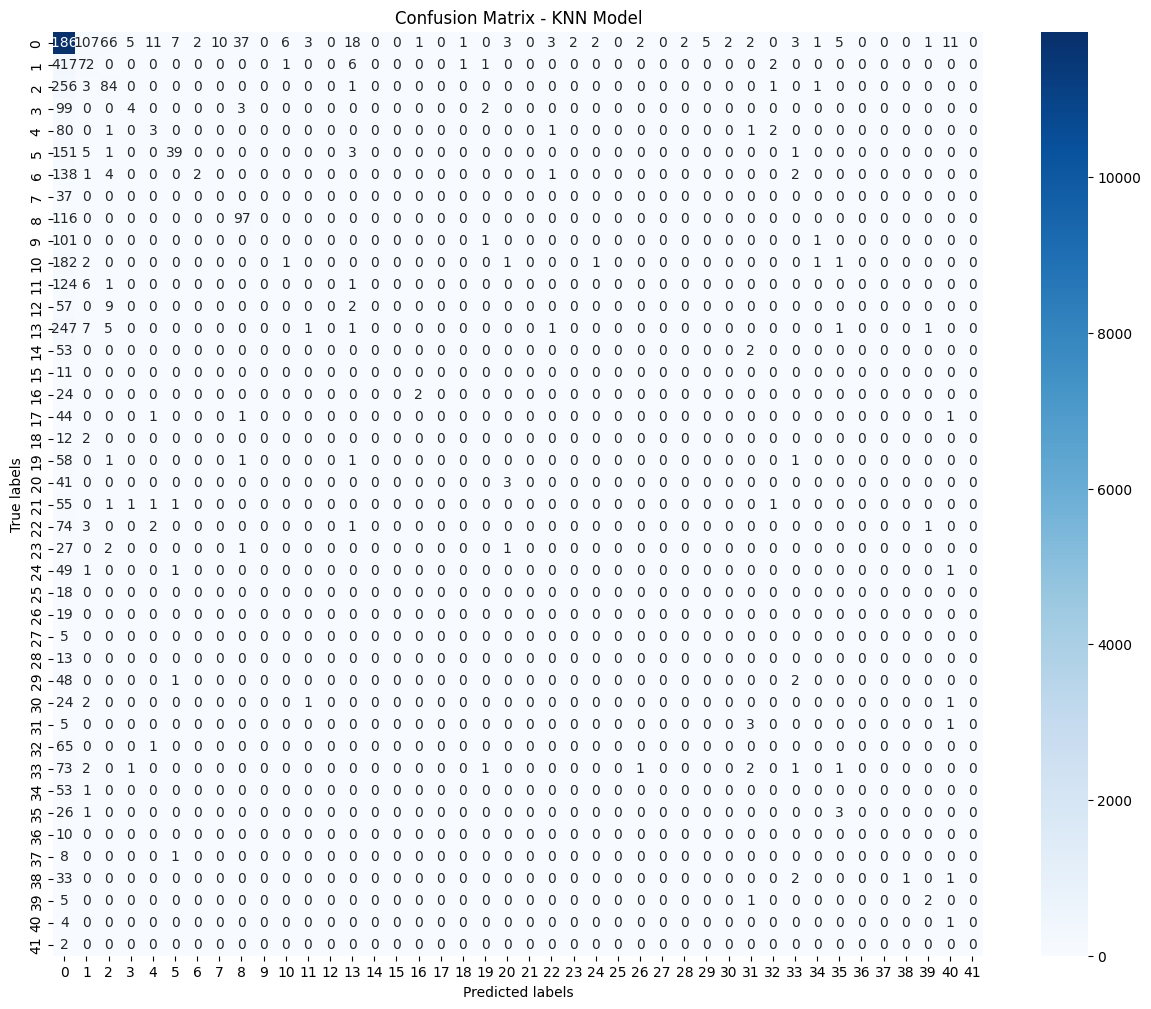

In [40]:
# Create a KNN classifier model with 5 neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the KNN model using the training set
knn_model.fit(train_rows_list, train_label)

# Predict using the test set
y_pred_knn = knn_model.predict(test_rows_list)

# Calculate accuracy
accuracy_knn = accuracy_score(test_label, y_pred_knn)

# Print the accuracy of the KNN model
print(f"Accuracy (KNN): {accuracy_knn*100}%")

# Print classification report
print("Classification Report:")
print(classification_report(test_label, y_pred_knn))

# Calculate confusion matrix
conf_matrix_knn = confusion_matrix(test_label, y_pred_knn)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix_knn)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix_knn, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - KNN Model')
plt.show()

Classification Report (Navie Bayes):
              precision    recall  f1-score   support

           0       0.79      0.99      0.88     12184
           1       0.00      0.00      0.00       500
           2       0.00      0.00      0.00       346
           3       0.00      0.00      0.00       108
           4       0.00      0.00      0.00        88
           5       0.00      0.00      0.00       200
           6       0.00      0.00      0.00       148
           7       0.00      0.00      0.00        37
           8       0.47      0.37      0.41       213
           9       0.00      0.00      0.00       103
          10       0.00      0.00      0.00       189
          11       0.00      0.00      0.00       132
          12       0.00      0.00      0.00        68
          13       0.00      0.00      0.00       264
          14       0.00      0.00      0.00        55
          15       0.00      0.00      0.00        11
          16       0.00      0.00      0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


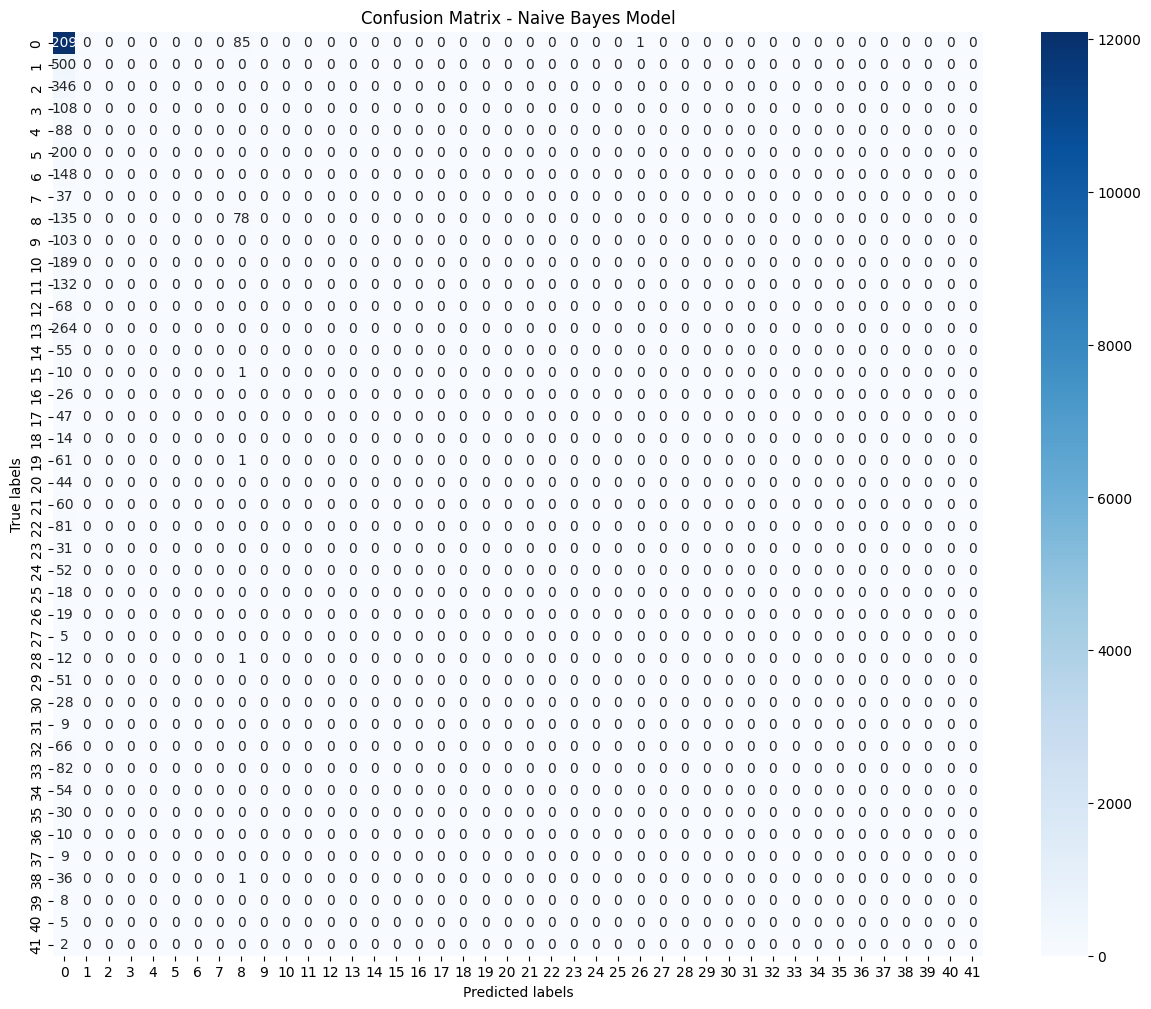

In [41]:
# Create a Multinomial Naive Bayes classifier model
nb_model = MultinomialNB()

# Train the Naive Bayes model using the training set
nb_model.fit(train_rows_list, train_label)

# Predict using the test set
y_pred_nb = nb_model.predict(test_rows_list)

# Print classification report
print("Classification Report (Navie Bayes):")
print(classification_report(test_label, y_pred_nb))

# Calculate accuracy
accuracy_nb = accuracy_score(test_label, y_pred_nb)

# Print the accuracy of the Naive Bayes model
print(f"Accuracy (Navie Bayes): {accuracy_nb*100}%")

# Calculate confusion matrix
conf_matrix_nb = confusion_matrix(test_label, y_pred_nb)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix_nb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Naive Bayes Model')
plt.show()